In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
from matplotlib import cm

import netCDF4 as nc

from pathlib import Path
import os
import glob
import pickle

### Prescriptions

* Prescriptions for Portugal and Spain [here](https://interior.gencat.cat/web/.content/home/030_arees_dactuacio/bombers/foc_forestal/publicacions_tecniques_i_normativa/guies_tecniques/cremes_prescrites/2010_Handbook-Plan-and-use-Prescribed-Burning-in-Europe_FireParadox.pdf)
* Prescriptions for New South Wales [here](https://www-sciencedirect-com.uea.idm.oclc.org/science/article/pii/S0168192319301091#bib0315)
* Prescriptions for South Australia [here](https://cdn.environment.sa.gov.au/environment/docs/prescribed-burning-operational-prescriptions-field-guide-gen.pdf); used values on pg 17 
* Prescriptions for Queensland [here](https://parks.des.qld.gov.au/__data/assets/pdf_file/0025/152890/pbg-brigalow-belt.pdf); used values on pg 29
* Prescriptions for Sweden
    * [here](https://www.metsa.fi/wp-content/uploads/2017/05/Granstrom_Controlled-burning_Sweden-1.pdf); pg 57
    * [here](https://www.metsa.fi/wp-content/uploads/2017/05/LIFE-TAIGA_Example-monitoring-report-Skattlosberg-1.pdf); pg 5
    * [here](https://www.metsa.fi/wp-content/uploads/2017/05/Lindberg_controlled_burning_Finland-1.pdf); pg 65
* Prescriptions for Northern Great Plains [here](https://fireecology.springeropen.com/articles/10.1186/s42408-019-0027-y#Sec1)
* Prescriptions for Oklahoma [here](https://extension.okstate.edu/fact-sheets/print-publications/e/oklahoma-prescribed-burning-handbook-e-1010.pdf); pg 11
* Prescriptions for South Africa Southwestern Cape [here](https://www.tandfonline.com/doi/pdf/10.1080/00382167.1987.9630282)

In [4]:
# Rx burning meteorological limits

### Units ###
# Temperature: Celsius
# Relative Humidity: %
# Wind: meters per second

# CA Sierra Nevada from Swain et al. 2023
CA_SN_T = [3,30]
CA_SN_W = [1,7]
CA_SN_RH = [18,68]

# Page 19, for shrubland burning; 2 meter wind
PRT_T = [8,20] # Celsius
PRT_W = [5/3.6,15/3.6] # m/s, convert to 10m
PRT_RH = [20,70] # %
PRT_FFDI = []

# New South Wales Coastal Bioregions from Clarke et al. 2019
NSW_T = [16.5,28.5]
NSW_W = [2/3.6/1.5,27.7/3.6/1.5]
NSW_RH = [30.7,56.4]
NSW_FFDI = [2,13]

# Brigalow Belt South, Eucalyptus Woodland; already at 10m wind speed
BBS_T = []
BBS_W = [10/3.6,23/3.6] # Convert to m/s
BBS_RH = []
BBS_FFDI = [0,13]
BBS_KBDI = [0,120]

# Average of Lundin 2015, Granstrom 2017, and Lindberg 2017
SW_T = []
SW_RH = [31.7,47.5]
SW_W = [0.67,4.83]
SW_FFDI = []
SW_DMC = [27.5,60]
SW_FFMC = [80,90]

### Regional data

In [5]:
# Read in master CSV
df = pd.read_csv('/path/to/master/GlobalRx/data.csv',low_memory=False)

# Convert all temperature values from Kelvin to Celsius
df.loc[:,'T_max'] = df['T_max'].values-273.15

# Get rid of any datapoints for which there is no temperature or RH data
df = df.loc[~np.isinf(df['T_max'])].loc[~np.isinf(df['RH'])]

# California Sierra Nevada dataframe
CA_df = df[df['Country']=='USA'].loc[df['State/Province']=='California']
CA_SN_df = df[CA_df['Ecoregion (Olson)']=='Sierra Nevada forests'].loc[CA_df['Topography']>=900]

# Portugal northern shrublands dataframe
PRT_df = df[df['Country']=='Portugal'].loc[df['Latitude']>39.5]
PRT_df['Wind_max'] = PRT_df['Wind_max']*0.67 # Convert from 10m to 2m wind

# Australia Brigalow Belt South dataframe
AUS_IBRA = gpd.read_file('Australia_shp/ibra7_regions.shp').to_crs('EPSG:4326')
BTS_df = df[df['Ecoregion (Olson)']=='Brigalow tropical savanna']
BBS_shp = AUS_IBRA[AUS_IBRA['REG_NAME_7']=='Brigalow Belt South']
BTS_pts = gpd.GeoDataFrame({'geometry':[Point(xy) for xy in zip(BTS_df['Longitude'],BTS_df['Latitude'])]})
BTS_pts.crs = 'EPSG:4326'
BTS_join = gpd.sjoin(BTS_pts,BBS_shp)
BBS_df = BTS_df.iloc[BTS_join.index]

# Sweden dataframe
SW_df = df[df['Country']=='Sweden']
SW_df.loc[:,'Wind_max'] = SW_df['Wind_max'].values/2.5 # Convert from 10m to 2m wind for long, short, or mixed leaf conifer 

/tmp/ipykernel_18834/4056458553.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SW_df['Wind_max'] = SW_df['Wind_max']/2.5 # Convert from 10m to 2m wind for long, short, or mixed leaf conifer


### Box and Whisker Plots with Wind, T, and RH

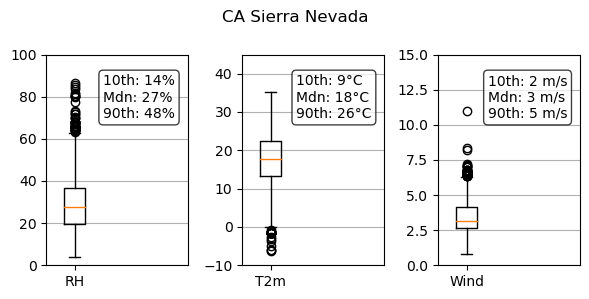

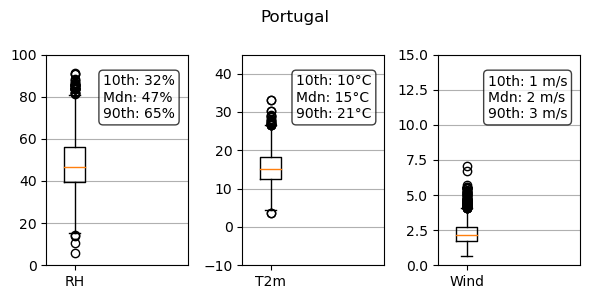

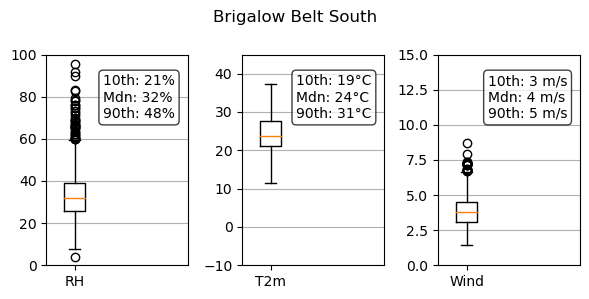

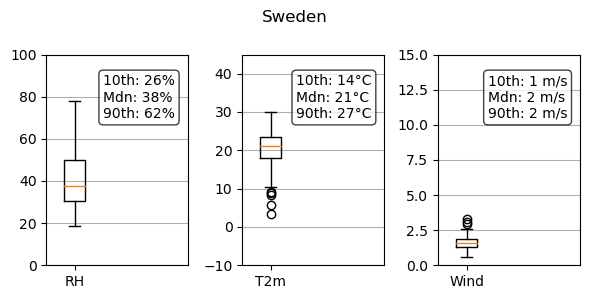

In [22]:
regions = ['CA Sierra Nevada','Portugal',
           'Brigalow Belt South','Sweden',]
i=0
for df in [CA_SN_df,PRT_df,BBS_df,SW_df]:
    fig,ax = plt.subplots(1,3,figsize=(6,3))
    RH_md = round(np.median(df['RH_min'].dropna(how='any')))
    RH_90 = round(np.percentile(df['RH_min'].dropna(how='any'),90))
    RH_10 = round(np.percentile(df['RH_min'].dropna(how='any'),10))
    T_md = round(np.median(df['T2m'].dropna(how='any')))
    T_90 = round(np.percentile(df['T2m'].dropna(how='any'),90))
    T_10 = round(np.percentile(df['T2m'].dropna(how='any'),10))
    W_md = round(np.median(df['Wind_max'].dropna(how='any')))
    W_90 = round(np.percentile(df['Wind_max'].dropna(how='any'),90))
    W_10 = round(np.percentile(df['Wind_max'].dropna(how='any'),10))
    
    bp0 = ax[0].boxplot(df['RH_min'].dropna(how='any'),labels=['RH'],positions=[0.2])
    bp1 = ax[1].boxplot(df['T2m'].dropna(how='any'),labels=['T2m'],positions=[0.2])
    bp2 = ax[2].boxplot(df['Wind_max'].dropna(how='any'),labels=['Wind'],positions=[0.2])
    
    ax[0].set_xlim([0,1])
    ax[0].set_ylim([0,100])
    ax[1].set_xlim([0,1])
    ax[1].set_ylim([-10,45])
    ax[2].set_xlim([0,1])
    ax[2].set_ylim([0,15])
    
    ax[0].grid(axis='y')
    ax[1].grid(axis='y')
    ax[2].grid(axis='y')
    
    ax[0].annotate('10th: '+str(RH_10)+'%'+'\nMdn: '+str(RH_md)+'%'+'\n90th: '+str(RH_90)+'%',xy=(0.4,0.7),xycoords='axes fraction',
                  bbox = dict(boxstyle='round',facecolor='white',alpha=0.75,edgecolor=None))
    deg = u'\N{DEGREE SIGN}'
    ax[1].annotate('10th: '+str(T_10)+deg+'C'+'\nMdn: '+str(T_md)+deg+'C'+'\n90th: '+str(T_90)+deg+'C',xy=(0.38,0.7),xycoords='axes fraction',
                  bbox = dict(boxstyle='round',facecolor='white',alpha=0.75,edgecolor=None))
    ax[2].annotate('10th: '+str(W_10)+' m/s'+'\nMdn: '+str(W_md)+' m/s'+'\n90th: '+str(W_90)+' m/s',xy=(0.35,0.7),xycoords='axes fraction',
                  bbox = dict(boxstyle='round',facecolor='white',alpha=0.75,edgecolor=None))
    
    fig.suptitle(regions[i])
    i+=1
    plt.tight_layout()

### 2D Histogram Function
#### Summary:
This function creates a 2D histogram of two meteorological variables at a time in the GlobalRx data, flanked by 1D histograms. If specified, the recommended prescription ranges are plotted on the the histograms as red lines.

**<u>Inputs</u>**:
* <code>df</code>:
    * **Input type**: Pandas DataFrame
    * **Description**: The regional DataFrame. For example, if you want to plot a 2D histogram of California Sierra Nevada data, this input would be <code>CA_SN_df</code>. Should contain columns with the meteorological variables' data.
* <code>var2</code>:
    * **Input type**: string (e.g., <code>'T_max'</code>)
    * **Description**: the first meteorological variable you want in the histogram. This variable appears on the x-axis of the 2D histogram. Check for the name of the meteorological variable in the columns of <code>df</code>. For example, the daily maximum temperature values are stored in a column called <code>T_max</code>.
* <code>var1</code>:
    * **Input type**: string (e.g., <code>'Wind_max'</code>)
    * **Description**: the second meteorological variable you want in the histogram. This variable appears on the y-axis of the 2D histogram. Check for the name of the meteorological variable in the columns of <code>df</code>. For example, the daily maximum wind speed values are stored in a column called <code>Wind_max</code>.
* <code>varlim2</code>:
    * **Input type**: list (e.g., <code>[3,30]</code>)
    * **Description**: the prescription limit for the first meteorological variable (<code>var2</code>) in the histogram. The range will appear as red lines in both the 2D histogram and corresponding 1D histogram.
* <code>varlim1</code>:
    * **Input type**: list (e.g., <code>[1,7]</code>)
    * **Description**: the prescription limit for the first meteorological variable (<code>var1</code>) in the histogram. The range will appear as red lines in both the 2D histogram and corresponding 1D histogram.
* <code>region</code>:
    * **Input type**: string (e.g., <code>'California Sierra Nevada'</code>
    * **Description**: what you want to title the region you are plotting. This input is used to set the title of the plot.
    
You can choose from the following meteorological variables in this function, which are also color coded as written below:
* <span style="color:orange">**T_max**</span>
* <span style="color:blue">**RH_mean, RH_min**</span>
* <span style="color:green">**Wind_mean, Wind_max**</span>
* <span style="color:darkred">**FFDI**</span>
* <span style="color:gold">**DMC**</span>
* <span style="color:hotpink">**KBDI**</span>


In [44]:
def plot2d_Rx(df,var2,var1,varlim2,varlim1,region):
    
    df_clean = df.dropna(how='any',subset=[var1,var2])
    if varlim1 and varlim2:
        burn_pct = len(df_clean[(df_clean[var1]<=varlim1[1])&(df_clean[var1]>=varlim1[0])&(df_clean[var2]<=varlim2[1])&(df_clean[var2]>=varlim2[0])])/len(df_clean)
    fig,ax = plt.subplots(2,2,gridspec_kw={'width_ratios':[5,1],'height_ratios':[1,5]},figsize=(6,6),
                          sharex='col',sharey='row')
    ax = ax.ravel()
        
    if (var1 == 'Wind_max') or (var1 == 'Wind_mean'):
        col1 = 'green'
        ylabel = 'Wind Speed, m/s'
        ylim = [0,10]
        W_lim = varlim1
        ticks1 = [1,3,5,7,9]
        var1_lab = 'Wind'
    if (var2 == 'Wind_max') or (var2 == 'Wind_mean'):
        col2 = 'green'
        xlabel = 'Wind Speed, m/s'
        xlim = [0,10]
        W_lim = varlim2
        ticks2 = [1,3,5,7,9]
        var2_lab = 'Wind'
    if (var1 == 'RH_min') or (var1 == 'RH_mean'):
        col1 = 'blue'
        ylabel = 'Relative Humidity, %'
        ylim = [0,100]
        RH_lim = varlim1
        ticks1 = [10,30,50,70,90]
        var1_lab = 'RH'
    if (var2 == 'RH_min') or (var2 == 'RH_mean'):
        col2 = 'blue'
        xlabel = 'Relative Humidity, %'
        xlim = [0,100]
        RH_lim = varlim2
        var2_lab = 'RH'
        ticks2 = [10,30,50,70,90]
    if var1 == 'T_max':
        col1 = 'darkorange'
        ylabel = '2-Meter Temperature, '+u'\N{DEGREE SIGN}'+'C'
        ylim = [0,40]
        T_lim = varlim1
        var1_lab = 'T2m'
        ticks1 = [0,5,10,15,20,25,30,35,40]
    if var2 == 'T_max':
        col2 = 'darkorange'
        xlabel = '2-Meter Temperature, '+u'\N{DEGREE SIGN}'+'C'
        xlim = [0,40]
        T_lim = varlim2
        var2_lab = 'T2m'
        ticks2 = [0,5,10,15,20,25,30,35,40]
    if var1 == 'FFDI':
        col1 = 'gold'
        ylabel = 'McArthur Forest Fire Danger Index'
        ylim = [0,30]
        FFDI_lim = varlim1
        var1_lab = var1
        ticks1 = [5,10,15,20,25]
    if var2 == 'FFDI':
        col2 = 'gold'
        xlabel = 'McArthur Forest Fire Danger Index'
        xlim = [0,30]
        FFDI_lim = varlim2
        var2_lab = var2
        ticks2 = [5,10,15,20,25]
    if var1 == 'DMC':
        col1 = 'purple'
        ylabel = 'Duff Moisture Code'
        ylim = [0,90]
        FFDI_lim = varlim1
        var1_lab = var1
        ticks1 = [10,30,50,70,90]
    if var2 == 'DMC':
        col2 = 'purple'
        xlabel = 'Duff Moisture Code'
        xlim = [0,90]
        FFDI_lim = varlim2
        var2_lab = var2
        ticks2 = [10,30,50,70,90]
    if var1 == 'KBDI':
        col1 = 'deeppink'
        ylabel = 'Keetch-Byram Drought Index'
        ylim = [0,90]
        FFDI_lim = varlim1
        var1_lab = var1
        ticks1 = [20,40,60,80,100]
    if var2 == 'KBDI':
        col2 = 'deeppink'
        xlabel = 'Keetch-Byram Drought Index'
        xlim = [0,120]
        FFDI_lim = varlim2
        var2_lab = var2
        ticks2 = [20,40,60,80,100]
    if var1 == 'FFMC':
        col1 = 'maroon'
        ylabel = 'Fine Fuel Moisture Code'
        ylim = [40,100]
        FFDI_lim = varlim1
        var1_lab = var1
        ticks1 = [50,60,70,80,90]
    if var2 == 'FFMC':
        col2 = 'maroon'
        xlabel = 'Fine Fuel Moisture Code'
        xlim = [40,100]
        FFDI_lim = varlim2
        var2_lab = var2
        ticks2 = [50,60,70,80,90]
        
    counts = ax[0].hist(df_clean[var2].values,bins=20,color=col2,edgecolor='black',linewidth=0.4)
    if varlim2:
        var2_pct = 100*len(df_clean[(df_clean[var2]<varlim2[1])&(df_clean[var2]>varlim2[0])])/len(df_clean)
        vlines = ax[0].vlines(varlim2,ymin=0,ymax=max(counts[0])*1.1,colors='red',label=str(round(var2_pct))+'% Burns in\n'+var2_lab+' Range')
        if len(str(round(var2_pct)))>2:
            x = 0.7
        else:
            if ('FFMC' in var2):
                x = 0.02
            else:
                x = 0.725
        ax[0].annotate(str(round(var2_pct))+'% Burns in\n'+var2_lab+' Range',xy=(x,0.55),xycoords='axes fraction',fontsize=10,
                      color=col2,bbox=dict(boxstyle='round',facecolor='white',alpha=0.75,edgecolor=None),weight='bold')
    ax[0].set_ylim([0,max(counts[0])*1.1])

    ax[2].hist2d(df_clean[var2].values,df_clean[var1].values,bins=20)
    ax[2].set_xlabel(xlabel,fontsize=16,color=col2,weight='bold')
    ax[2].set_ylabel(ylabel,fontsize=16,color=col1,weight='bold')
    ax[2].set_xlim(xlim)
    ax[2].set_ylim(ylim)
    ax[2].set_facecolor([68/255,1/255,84/255])
    if varlim2 and varlim1:
        vlines = ax[2].vlines(varlim2,ymin=varlim1[0],ymax=varlim1[1],colors='red',label='Prescription for\n'+var2_lab+' and '+var1_lab)
        hlines = ax[2].hlines(varlim1,xmin=varlim2[0],xmax=varlim2[1],colors='red')
        ax[2].annotate(str(round(burn_pct*100))+'% Burns in '+var2_lab+'\nand '+var1_lab+' Range',xy=(0.598,0.78),xycoords='axes fraction',
                      color='k',bbox = dict(boxstyle='round',facecolor='white',alpha=0.75,edgecolor=None),weight='bold')
        leg = ax[2].legend(handles=[vlines])

    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].spines[['right','left','top','bottom']].set_visible(False)

    counts = ax[3].hist(df_clean[var1].values,bins=20,orientation='horizontal',color=col1,edgecolor='black',linewidth=0.4)
    if varlim1:
        var1_pct = 100*len(df_clean[(df_clean[var1]<=varlim1[1])&(df_clean[var1]>=varlim1[0])])/len(df_clean)
        vlines = ax[3].hlines(varlim1,xmin=0,xmax=max(counts[0])*1.1,colors='red',label=str(round(var1_pct))+'% Burns in\n'+var1_lab+' Range')
        if len(str(round(var1_pct)))>2:
               y = 0.695
        else:
            if ('FFMC' in var1):
                y = 0.04
            else:
                y = 0.72
        ax[3].annotate(str(round(var1_pct))+'% Burns in\n'+var1_lab+' Range',xy=(0.54,y),xycoords='axes fraction',fontsize=10,weight='bold',
                      color=col1,bbox = dict(boxstyle='round',facecolor='white',alpha=0.75,edgecolor=None),rotation=-90)
    ax[3].set_xlim([0,max(counts[0])*1.1])

    start_year = np.unique(df_clean['Year'])[0]
    end_year = np.unique(df_clean['Year'])[-1]
    plt.suptitle(region+' Rx Burns '+str(start_year)+'-'+str(end_year))
    plt.tight_layout()
    fig.patch.set_alpha(0.0)
    
    if df['Country'].iloc[0]=='Sweden' and len(SW_T)!=0 and (((var1=='RH' and var2=='T_max') or (var1=='T_max' and var2=='RH')) 
                                            or ((var1=='RH_min' and var2=='T_max') or (var1=='T_max' and var2=='RH_min'))
                                            or ((var1=='RH_mean' and var2=='T_max') or (var1=='T_max' and var2=='RH_mean'))):
        if (var1=='RH_min') or (var2=='RH_min'):
            RH = 'RH_min'
        if (var1=='RH_mean') or (var2=='RH_mean'):
            RH = 'RH_mean'
        RH_pct = 100*len(df_clean[(df_clean[RH]>=df_clean['T_max'])])/len(df_clean)
        if 'RH' in var2:
            ax[0].annotate(str(round(RH_pct))+'% Burns in\n'+'RH Range',xy=(0.725,0.55),xycoords='axes fraction',fontsize=10,
                          color='blue',bbox=dict(boxstyle='round',facecolor='white',alpha=0.75,edgecolor=None),weight='bold')
        else:
            ax[3].annotate(str(round(RH_pct))+'% Burns in\n'+'RH Range',xy=(0.54,0.72),xycoords='axes fraction',fontsize=10,
                          color='blue',bbox=dict(boxstyle='round',facecolor='white',alpha=0.75,edgecolor=None),weight='bold',rotation=-90)
        ax[2].plot(np.arange(0,42),np.arange(0,42),color='red')
        
        try:
            hlines = ax[2].hlines(varlim1[0],xmin=varlim1[0],xmax=100,colors='red',label='Prescription for\n'+var1_lab+' and '+var2_lab)
            ax[2].hlines(varlim1[1],xmin=varlim1[1],xmax=100,colors='red')
        except:
            vlines = ax[2].vlines(varlim2[0],ymin=varlim2[0],ymax=100,colors='red',label='Prescription for\n'+var2_lab+' and '+var1_lab)
            ax[2].vlines(varlim2[1],ymin=varlim2[1],ymax=100,colors='red')
        burn_pct = len(df_clean[(df_clean['T_max']<=SW_T[1])&(df_clean['T_max']>=SW_T[0])&(df_clean[RH]>=df_clean['T_max'])])/len(df_clean)
        ax[2].annotate(str(round(burn_pct*100))+'% Burns in '+var2_lab+'\nand '+var1_lab+' Range',xy=(0.604,0.78),xycoords='axes fraction',
                      color='k',bbox = dict(boxstyle='round',facecolor='white',alpha=0.75,edgecolor=None),weight='bold')
        try:
            leg = ax[2].legend(handles=[hlines])
        except:
            leg = ax[2].legend(handles=[vlines])
    fig.savefig('/path/to/figures/figure.png',transparent=False,bbox_inches='tight')

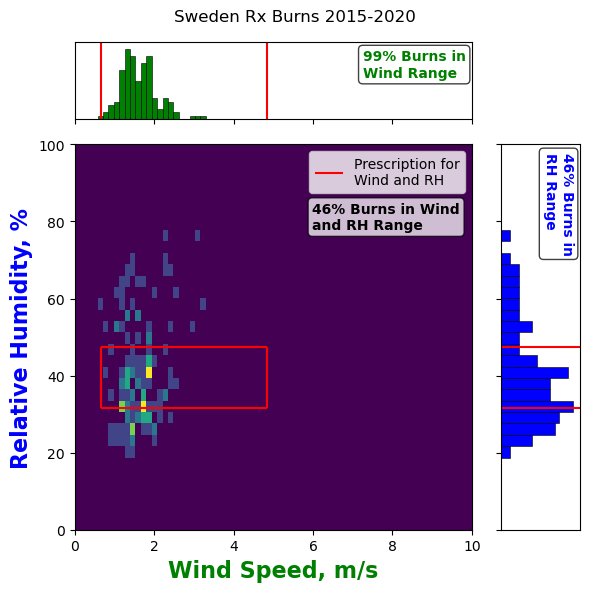

In [45]:
plot2d_Rx(SW_df,'Wind_max','RH_min',SW_W,SW_RH,'Sweden')

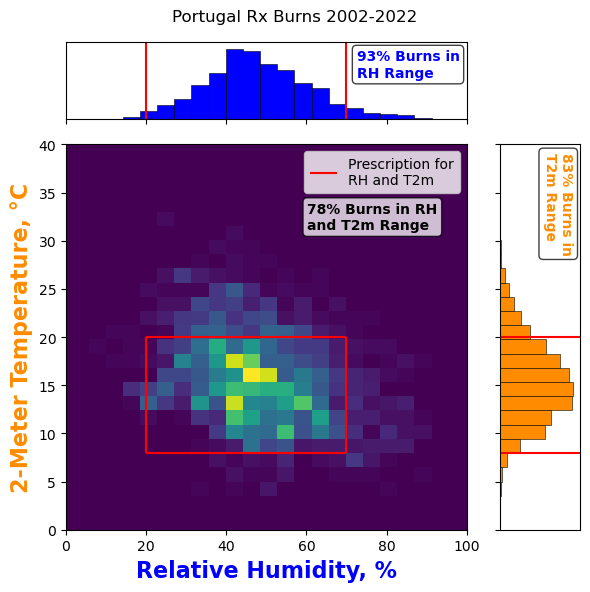

In [74]:
plot2d_Rx(PRT_df,'RH_min','T2m',PRT_RH,PRT_T,'Portugal')

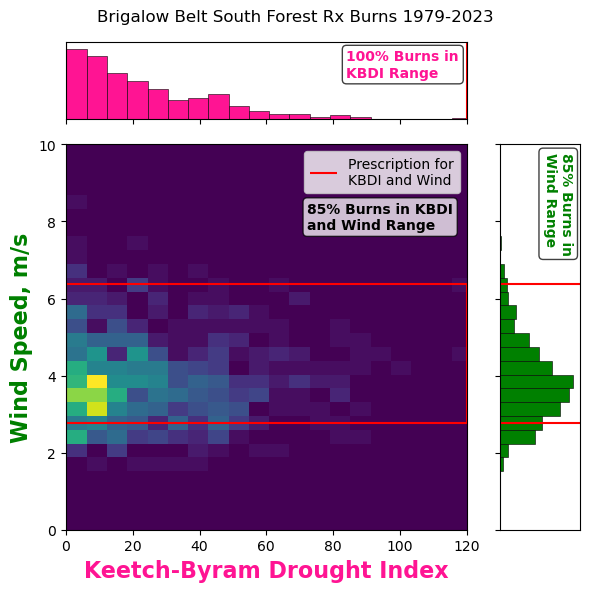

In [125]:
plot2d_Rx(BBS_df,'KBDI','Wind_max',BBS_KBDI,BBS_W,'Brigalow Belt South Forest')

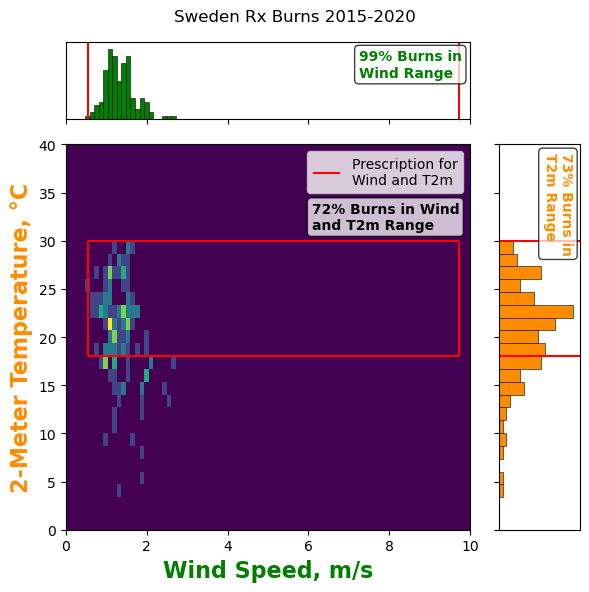

In [34]:
plot2d_Rx(SW_df,'Wind_max','T2m',SW_W,SW_T,'Sweden')

### Create colorbar

In [20]:
def create_colorbar(df):
    dec = -str(len(df))+2
    factor = (10**-dec)*4
    end_tick = np.round(df+4,decimals=dec)
    ticks = np.linspace(0,end_tick,5)
    img = plt.imshow(np.array([ticks]),cmap="viridis")
    img.set_visible(False)

    plt.colorbar(orientation="vertical",ticks=ticks)
    plt.style.use("dark_background")
    print(end_tick)
#     plt.savefig('Figures/colorbar.png',transparent=True,bbox_inches='tight')

130


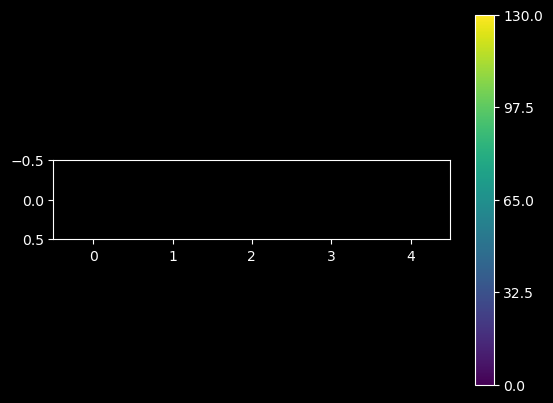

In [25]:
create_colorbar(124)

In [11]:
np.array([[0,25,50,75,100,125]])

array([[  0,  25,  50,  75, 100, 125]])